In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [190]:
df = pd.read_csv('sales_data.csv')
df['sale_date'] = pd.to_datetime(df['sale_date'])
df["quarter"] = df.sale_date.dt.quarter

In [205]:
def myfunc(q):

    # Filtering by quarter
    my_df = df[df.quarter == q]

    # Grouping by product_id and sum the quantities
    my_df_grouped = my_df.groupby('product_id').sum('quantity')

    # Compute the naive popularity index and scale it
    my_df_grouped['pop_index'] = my_df_grouped['quantity'] / my_df_grouped['quantity'].sum()
    my_df_grouped['pop_index_perc'] = (my_df_grouped['pop_index'] - my_df_grouped['pop_index'].min())\
                                            / (my_df_grouped['pop_index'].max() - my_df_grouped['pop_index'].min())

    # Compute the revenues index and scale it
    my_df_grouped['revenues'] = my_df_grouped['quantity'] * my_df_grouped['sales_price']
    my_df_grouped['revenues_perc'] = (my_df_grouped['revenues'] - my_df_grouped['revenues'].min())\
                                            / (my_df_grouped['revenues'].max() - my_df_grouped['revenues'].min())

    my_df_grouped.reset_index(inplace = True)
    return my_df_grouped

var = myfunc(4)

In [206]:
def ABC(X):
    top_ten = list(var[var['pop_index_perc'] > X].product_id.unique().tolist())
    my_df = var[var['product_id'].isin(top_ten)].reset_index(drop = True)
    print('Contribution to total revenues of the {} most popular products:'.format(X), my_df.revenues.sum()/var.revenues.sum())
ABC(0.1)

Contribution to total revenues of the 0.1 most popular products: 0.5568674537474468


/Users/Vincenzo/PycharmProjects/task2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Vincenzo/PycharmProjects/task2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


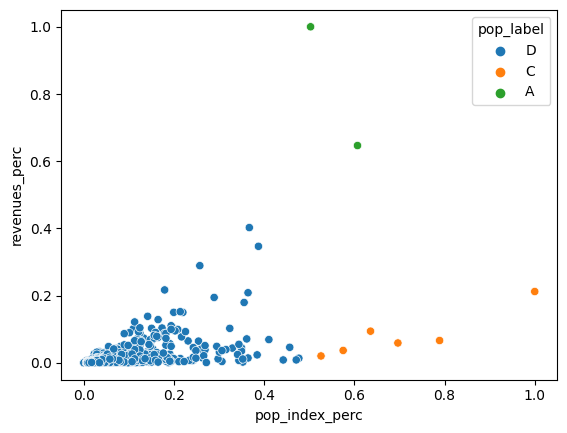

In [207]:
def vincolo():

    var['pop_label'] = 'D'
    for i in range(len(var)):
        if (var['pop_index_perc'][i] > 0.5) & (var['revenues_perc'][i] > 0.5):
            var['pop_label'][i] = 'A'
        elif (var['pop_index_perc'][i] < 0.5) & (var['revenues_perc'][i] > 0.5):
            var['pop_label'][i] = 'B'
        elif (var['pop_index_perc'][i] > 0.5) & (var['revenues_perc'][i] < 0.5):
            var['pop_label'][i] = 'C'

    sns.scatterplot(data=var, x='pop_index_perc', y='revenues_perc', hue='pop_label')

vincolo()